# get_prc_data

This script generates precision-recall data for the given model and saves it as .csv file.

In [1]:
import pandas as pd
import numpy as np
import h5py as h5
import matplotlib.pyplot as plt

## Models

### seismo-performer(s)

In [6]:
# Modifying sys.path to be able to load seismo-performer modules
import sys
sys.path.append('../../seismo-performer/')
sys.path.append('../../seismo-performer/utils')

In [7]:
import seismo_load

In [9]:
models = {'sp_new': seismo_load.load_performer('C:/dev/seismo-performer/WEIGHTS/w_model_performer_with_spec.hd5'),
          'sp_old': seismo_load.load_performer('C:/dev/seismo-performer/WEIGHTS/w_model_performer_combined_learned.h5')}
          
# seismo_load.load_cnn('C:/dev/seismo-transformer/WEIGHTS/weights_model_cnn_spec.hd5')

### gpd

In [10]:
import gpd_loader

In [15]:
model_gpd = gpd_loader.load_model('C:/dev/seismo-performer/WEIGHTS/w_gpd_scsn_2000_2017.h5')
models['gpd'] = model_gpd

## PRC utility

In [16]:
def get_prc_info(model, X, Y):
    """
    Predicts data on model and return percision-recall 
    curve info (each prediction info: predicted label, true label, probability) as pandas.DataFrame
    """
    
    scores = model.predict(X)
    
    Y_true = np.array(Y, dtype = 'int')
    Y_pred = scores.argmax(axis = 1)
    Y_score = scores.max(axis = 1)
    
    return pd.DataFrame({'Y_true': Y_true, 'Y_pred': Y_pred, 'Y_score': Y_score})


def get_data(data):
    """
    Returns data for later PRC building.
    Parameters:
    data - string to .csv file or pandas DataFrame object
    """
    from pandas.core.frame import DataFrame
    
    if type(data) == str:
        data = pd.read_csv(data)
        
    if type(data) == DataFrame:
        return data.to_numpy()
    
    return None


def predict_data(model, path):
    """
    Predicts data on model and return percision-recall 
    curve info (each prediction info: predicted label, true label, probability) as pandas.DataFrame
    """
    
    with h5.File(path, 'r') as data:
        
        return get_data(get_prc_info(model, data['X'], data['Y']))


def get_prc_data(data, true_label, threshold):
    """
    Return number of true positives, false positives and false negatives.
    Data shape: <row, column>. columns: 0 - true label, 1 - predicted label, 2 - probability.
    """
    tp = fp = fn = 0
    for i in range(data.shape[0]):
        
        if data[i][2] >= threshold:
            y_pred = data[i][1]
        else:
            y_pred = -1
            
        if data[i][0] == y_pred == true_label:
            tp += 1
        elif y_pred == true_label:
            fp += 1
        elif data[i][0] == true_label:
            fn += 1
            
    if tp + fp != 0:
        precision = tp / (tp + fp)
    else:
        precision = np.Inf
    if tp + fn != 0:
        recall = tp / (tp + fn)
    else:
        recall = np.Inf
            
    return {'tp': tp, 'fp': fp, 'fn': fn, 'precision': precision, 'recall': recall}


def plot_prc(data, label, thresholds):
    """
    Gather and plot percision/recall curve.
    """
    # Gather data
    precision = []
    recall = []
    
    for t in thresholds:
        
        prc_data = get_prc_data(data, label, t)
        
        precision.append(prc_data['precision'])
        recall.append(prc_data['recall'])
        
    # Plot PRC
    plt.plot(recall, precision)


def append_prc(data, label, threshold, precision, recall):
    
    prc_data = get_prc_data(data, label, threshold)
    precision.append(prc_data['precision'])
    recall.append(prc_data['recall'])
    

def precision_recall_single(data):
    
    precision_P = []
    precision_S = []
    precision_N = []
    
    recall_P = []
    recall_S = []
    recall_N = []
    
    for t in thresholds:
        
        append_prc(data, 0, t, precision_P, recall_P)
        append_prc(data, 1, t, precision_S, recall_S)
        append_prc(data, 2, t, precision_N, recall_N)
        
    return {'precision': {'p': precision_P, 's': precision_S, 'n': precision_N}, 
            'recall': {'p': recall_P, 's': recall_S, 'n': recall_N}}


def precision_recall(data_1, data_2):
    
    precision_1_P = []
    recall_1_P = []
    precision_2_P = []
    recall_2_P = []
    
    precision_1_S = []
    recall_1_S = []
    precision_2_S = []
    recall_2_S = []
    
    for t in thresholds:
        
        append_prc(data_1, 0, t, precision_1_P, recall_1_P)
        append_prc(data_1, 1, t, precision_1_S, recall_1_S)
        
        append_prc(data_2, 0, t, precision_2_P, recall_2_P)
        append_prc(data_2, 1, t, precision_2_S, recall_2_S)
        
    return [precision_1_P, precision_1_S, precision_2_P, precision_2_S], [recall_1_P, recall_1_S, recall_2_P, recall_2_S]


def plot_prc_final(precision_recall, colors, labels, save_path = None):
    """
    Gather and plot percision/recall curve.
    """
    from matplotlib.ticker import FormatStrFormatter
    
    # Set shorter alias
    pr = precision_recall
    
    # Plot PRC
    fig = plt.figure(figsize = (7, 3), dpi = 300)
    axes = fig.subplots(1, 2, sharey = True)
    
    fig.text(0.512, 0.00, 'Recall', va = 'center')
    
    middle_point = 4
    mark_size = 4.
    star_size = 8.
    
    axes[0].set_ylabel('Precision')
    
    star_color = '#d00000'
    
    # P
    
    for key, data in precision_recall.items():
        
        axes[0].plot(data['recall']['p'], data['precision']['p'],
                    '-^', linewidth = 1., markersize = mark_size,
                    color = colors[key], label = labels[key])
        
        axes[0].plot(data['recall']['p'][middle_point], data['precision']['p'][middle_point],
                     '*', color = star_color, markersize = star_size)
    
    # S
    
    for key, data in precision_recall.items():
        
        axes[1].plot(data['recall']['s'], data['precision']['s'],
                    '-^', linewidth = 1., markersize = mark_size,
                    color = colors[key])
        
        axes[1].plot(data['recall']['s'][middle_point], data['precision']['s'][middle_point],
                     '*', color = star_color, markersize = star_size)
    
    ticks = np.array([0.825, 0.85, 0.875, 0.90, 0.925, 0.95, 0.975])
    
    axes[0].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    axes[1].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # axes[2].xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    # axes[0].set_xticks(ticks)
    # axes[1].set_xticks(ticks)
    # axes[2].set_xticks(ticks)
    
    # axes[0].set_xlim(0.55, 1.)
    # axes[1].set_xlim(0.55, 1.)
    # axes[2].set_xlim(0.725, 1.)
    
    axes[0].legend()
    
    axes[0].set_title('P-Wave')
    axes[1].set_title('S-Wave')
    # axes[2].set_title('N')
    
    fig.tight_layout()
    
    if save_path: fig.savefig(save_path)

## PRC

In [14]:
thresholds = np.linspace(0.1, 0.9, 9)
thresholds

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

In [17]:
# 'C:/data/datasets/sh_bh_datasets/dagestan_2014_2020_global_norm_sh_bh.h5'
# 'C:/data/datasets/sh_bh_datasets/2014_2021_global_norm_sh_bh.h5'

# 'C:/data/paper_06_2021/ross_2014_2019_prc.csv'
# 'C:/data/paper_06_2021/ross_dag_prc.csv'

dataset = 'C:/data/datasets/sh_bh_datasets/2014_2021_global_norm_sh_bh.h5'
data = {key: predict_data(model, dataset) for key, model in models.items()}

# data_gpd = get_data('C:/data/paper_06_2021/ross_2014_2019_prc.csv')

In [18]:
precision_recall = {key: precision_recall_single(x) for key, x in data.items()}

In [21]:
[key for key in precision_recall]

['sp_new', 'sp_old', 'gpd']

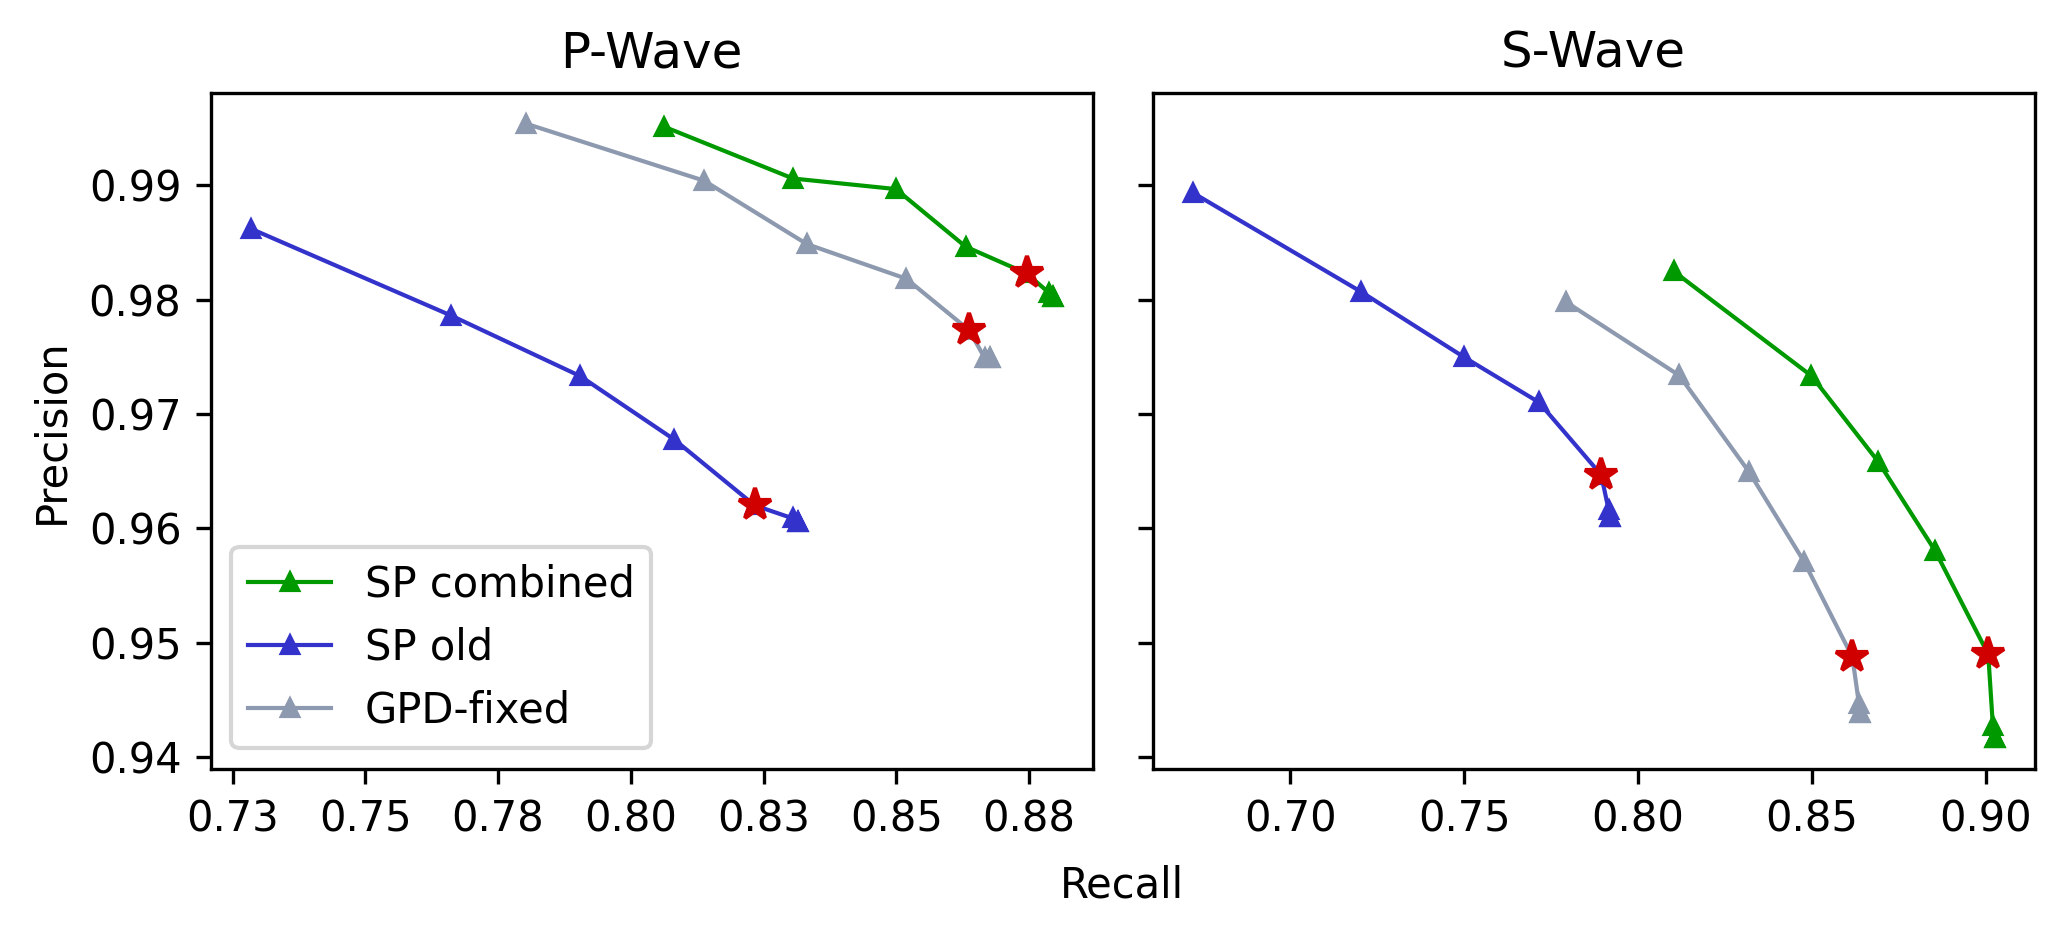

In [23]:
colors = {'sp_new': '#009900',
          'sp_old': '#3333cc',
          # 'gpd': '#2b2d42',
          'gpd': '#8d99ae'
         }

labels = {
          'sp_new': 'SP combined',
          'sp_old': 'SP old',
          # 'gpd': 'GPD',
          'gpd': 'GPD-fixed'
         }

plot_prc_final(precision_recall, colors, labels, 'C:/data/prc_saved.jpg')